# This notebook contains the algorithm for spatial clustering developed in the separate notebook
The second notebook (with analysis and development) is also provided in a separate file.

In [1]:
# importing all necessary libraries

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from tqdm import tqdm_notebook

import warnings

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

pd.options.display.float_format = '{:.4f}'.format

warnings.filterwarnings('ignore')

In [3]:
# reading in the provided data set

initial_df = pd.read_csv(r'C:\Users\79175\Desktop\BGI Group Recruiting/E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin_merge.tsv',
                delimiter = '\t')

# Restructuring the initial dataset in order for it to be used for clustering

The initial data set has to be restructured in such a way that:
   1. 'cell' is used as a unique index; 
   2. 'geneID' is used as a feature; 
   3. 'MIDCounts' is used to place the respective values inside each gene based feature.

In [4]:
# Creating a list containing all columns that will be in the final dataset
columns_for_restrucred_df = ['x', 'y']


for i in initial_df['geneID'].unique():
    columns_for_restrucred_df.append(i)

In [5]:
# Creating the restructured data set

restructured_df = pd.DataFrame(index = initial_df['cell'].unique(), columns = columns_for_restrucred_df)

In [6]:
# Fill in the values for x and y variables

for i in tqdm_notebook(restructured_df.index):
    restructured_df['x'].loc[i] = initial_df[initial_df['cell'] == i]['x'].mean()
    restructured_df['y'].loc[i] = initial_df[initial_df['cell'] == i]['y'].mean()

In [7]:
# Fill in the values for features based on cell genetic composition

for i in tqdm_notebook(restructured_df.index):
    d = initial_df[initial_df['cell'] == i][['geneID', 'MIDCounts']].T.to_dict()
    for j in d.keys():
        restructured_df[d[j]['geneID']].loc[i] = d[j]['MIDCounts']

### Restructuring complete
The restructured data set contains 18 700 features. A lot of entries in these features are missing. Missing values correspond to a gene being missing from a particular cell. <br>
The analysis has shown that to achieve a good clustering result it was enough for a training data set to contain 2 spatial features ('x', 'y') and gene-based features that are missing less than 90% of the entries. In other words, most abundant genes are used to cluster the data set.

In [8]:
# Percentage of empty cells in each feature

empty_feat_list = restructured_df.isnull().sum().sort_values(ascending = True)/len(restructured_df)*100

In [9]:
# Creating a list containing features that are missing less than 50% of entries

list_of_features_to_use = empty_feat_list.reset_index()[empty_feat_list.reset_index()[0] < 90]['index'].tolist()

In [10]:
# Removing features that are missing more than 90% of the entries from the restructured data set

restructured_df = restructured_df[list_of_features_to_use]

The restructured data set now has only features that will be used for clusterisation. However, each of these features (except for 'x' and 'y') still contain NaN values. <br>
In order to prepare the data set to be used for clustering NaN values are replaced with 0's. 0 is a reasonable fill value because NaN means that a particular gene is not present in a particular cell. Hence, it's logical that it's amount in the cell is 0.

In [11]:
# Filling NaN values with 0's

restructured_df = restructured_df.fillna(0)

### Data preparation part is finished

# KMeans Model Creation
After carrying out an extensive analysis it was found that Kmeans model with n_clusters parameter set to 9 gives good clustering results. This model is created in this section.

In [12]:
standard_scaler = StandardScaler()

In [13]:
k_means_training_df_scaled = standard_scaler.fit_transform(restructured_df)

In [14]:
k_means_model = KMeans(n_clusters=9)

In [15]:
k_means_model_results = k_means_model.fit_predict(k_means_training_df_scaled)

# Hierarchical Model Creation

In [16]:
min_max_scaler = MinMaxScaler()

In [17]:
aggl_model_training_df = min_max_scaler.fit_transform(restructured_df)

In [18]:
aggl_model = AgglomerativeClustering(n_clusters=9)

In [19]:
aggl_model_results = aggl_model.fit_predict(aggl_model_training_df)

### Both models that will be used in an ensemle are created. Now their results are combined into a single data set which later be used to run another clusterisation algorithm upon it.

In [20]:
# data that will be used to create a data frame containing the results of KMeans and Hirarchical models

data = {'KMEANS':k_means_model_results.tolist(), 'AGGL_CLST':aggl_model_results.tolist()}

In [21]:
# creating a data set that will contain the results of KMeans and Hierarchical algorithms 

ensemble_data = pd.DataFrame(data = data)

# Creating an ensemble model
In this section a final model is created wich takes in the results of KMeans and Hierarchical models as features. <br> <br>
The results of this final model are the results of this whole algorithm.

In [22]:
ensemble_model = KMeans(n_clusters=9)

In [23]:
scaled_ensemble_training_data = k_means_training_df_scaled

# Plotting final result

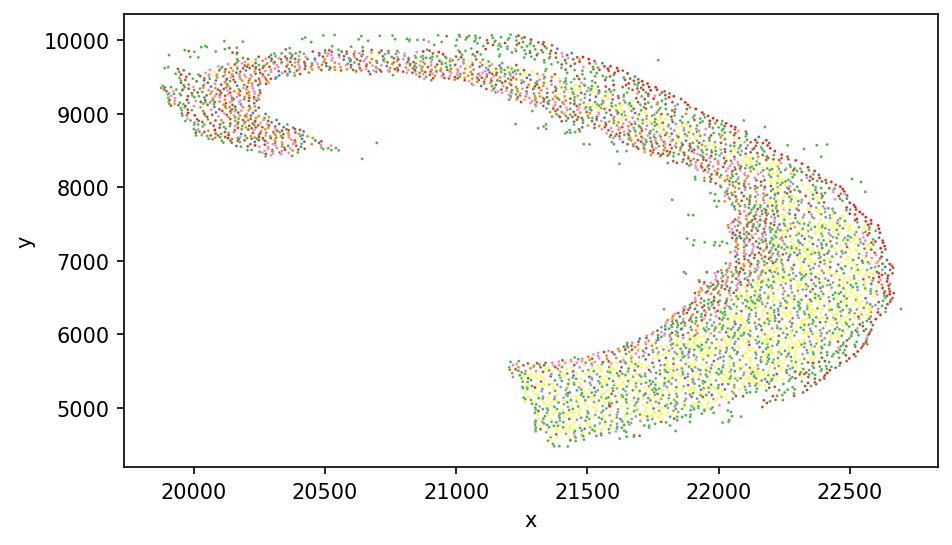

In [29]:
#Plotting the results of the ensemble model

plt.figure(figsize = (7,4), dpi = 150)

graph = sns.scatterplot(restructured_df['x'], restructured_df['y'], hue = ensemble_model.fit_predict(scaled_ensemble_training_data), palette = 'Set1', s = 2)

plt.legend([], [], frameon = False);